In [203]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from scipy.stats import chi2_contingency
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from scipy import stats
from dmba.metric import AIC_score
from mord import LogisticIT
from dmba import classificationSummary, gainsChart, liftChart

fraud_df= pd.read_csv(r"C:\Users\sanes\OneDrive\Desktop\Fall 2024\Machine Learning\Project\fraud_transactions_dataset.csv")

## *EDA PROCESS*

In [204]:
fraud_df.info()

#Create a copy of the data frame for other EDA processes
fraud_df_copy = fraud_df.copy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Transaction Amount  1000 non-null   float64
 1   Customer Age Group  1000 non-null   object 
 2   Merchant Category   1000 non-null   object 
 3   Transaction Time    1000 non-null   object 
 4   Payment Method      1000 non-null   object 
 5   Risk Score          1000 non-null   float64
 6   Fraudulent          1000 non-null   int64  
dtypes: float64(2), int64(1), object(4)
memory usage: 54.8+ KB


In [205]:
#Rename columns and replace space with '_' for ease of callability
fraud_df.columns=fraud_df.columns.str.replace(' ','_')
fraud_df_copy.columns=fraud_df.columns.str.replace(' ','_')
fraud_df.columns

Index(['Transaction_Amount', 'Customer_Age_Group', 'Merchant_Category',
       'Transaction_Time', 'Payment_Method', 'Risk_Score', 'Fraudulent'],
      dtype='object')

In [206]:
#Check for unique values in all variables except numeric
# Print column names with their unique values 
print(f"Unique values in 'Fraudulent': {fraud_df['Fraudulent'].unique()}", 
      f"Unique values in 'Customer_Age_Group': {fraud_df['Customer_Age_Group'].unique()}", 
      f"Unique values in 'Merchant_Category': {fraud_df['Merchant_Category'].unique()}", 
      f"Unique values in 'Transaction_Time': {fraud_df['Transaction_Time'].unique()}", 
      f"Unique values in 'Payment_Method': {fraud_df['Payment_Method'].unique()}")


Unique values in 'Fraudulent': [0 1] Unique values in 'Customer_Age_Group': ['Young Adult' 'Adult' 'Senior' 'Teen'] Unique values in 'Merchant_Category': ['Groceries' 'Clothing' 'Electronics' 'Dining'] Unique values in 'Transaction_Time': ['Afternoon' 'Night' 'Morning' 'Evening'] Unique values in 'Payment_Method': ['Debit Card' 'Bank Transfer' 'Credit Card']


**It was noted that these columns contained the following unique variables which coincided with our dataset, the numeric columns already have numeric data and did not need to tested**

In [207]:
#Check for null values
round((fraud_df.isnull().sum()/fraud_df.shape[0])*100,2)

Transaction_Amount    0.0
Customer_Age_Group    0.0
Merchant_Category     0.0
Transaction_Time      0.0
Payment_Method        0.0
Risk_Score            0.0
Fraudulent            0.0
dtype: float64

**There are no null values present**

In [208]:
#Check for duplicate values
total_duplicates = fraud_df.duplicated().head(1000).sum()
print("The total number of duplicated rows are:", total_duplicates)

The total number of duplicated rows are: 0


**There are no duplicated rows present**

<h3 align="center">Assess if dependent variable 'Fraudulent' has imbalanced data</h3>

In [209]:
# Count the number of fraudulent cases vs the number of non-fraudulent cases
fraud_df['Fraudulent'].value_counts()

Fraudulent
0    700
1    300
Name: count, dtype: int64

**Data is highly imbalanced**

<h3 align="center">Chi-Square Test (Independence of Observations) for Categorical Variables</h3>

In [210]:
#Create contingency table
contingency_table =pd.crosstab([fraud_df['Customer_Age_Group'],fraud_df['Transaction_Time'],fraud_df['Payment_Method']],fraud_df['Merchant_Category'])

# Perform Chi-Square test to assess independence of categorical variables
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-Square Statistic: {chi2}, p-value: {p}")

Chi-Square Statistic: 149.97822798663526, p-value: 0.28664659960065236


**Categorical variables are independent of each other as p value is greater than 0.05**

<h3 align="center">Check for Skewness</h3>

In [211]:
#Check if numerical columns are normal
num_col = [col for col in fraud_df.columns if fraud_df[col].dtype != 'object']
skew = fraud_df[num_col].skew()

print('The skewness for numerical colums are:', skew)


The skewness for numerical colums are: Transaction_Amount    4.384667
Risk_Score            0.452448
Fraudulent            0.874183
dtype: float64


**The data is not normal in columns 'Transaction_Amount' and 'Fradulent' given that the skewness is 4.38 and 0.87 which means the data is skewed since it's greater than 0.5**

<h3 align="center">Visualizing Skewness</h3>

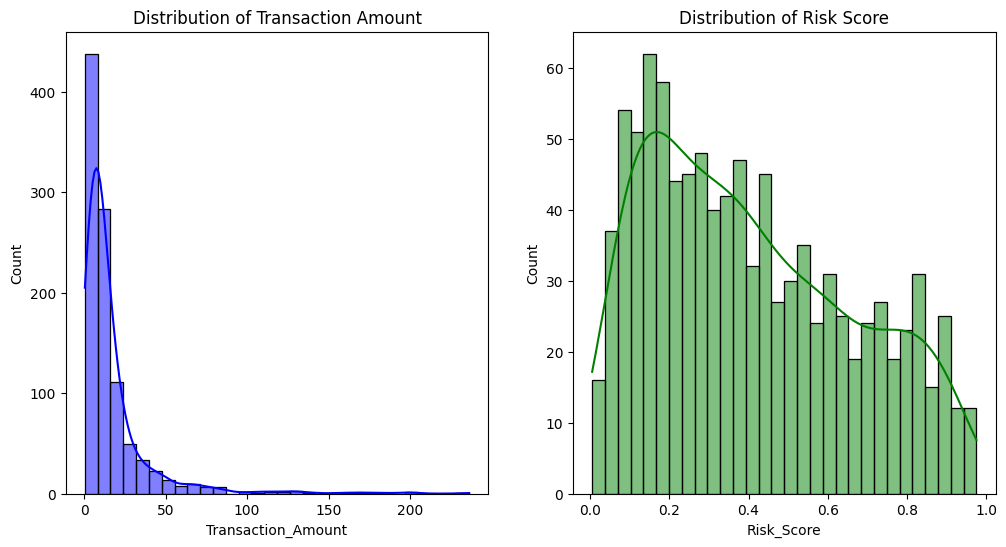

In [212]:
fig,axes = plt.subplots(1, 2,figsize=(12, 6)) 

#Create a histogram for the entire DataFrame
sns.histplot(fraud_df['Transaction_Amount'],ax=axes[0],kde=True, color='blue', bins=30).set_title('Distribution of Transaction Amount')
sns.histplot(fraud_df['Risk_Score'],ax=axes[1],kde=True, color='green', bins=30).set_title('Distribution of Risk Score')

# Show the plot
plt.show()

<h3 align="center">Check for Outliers</h3>

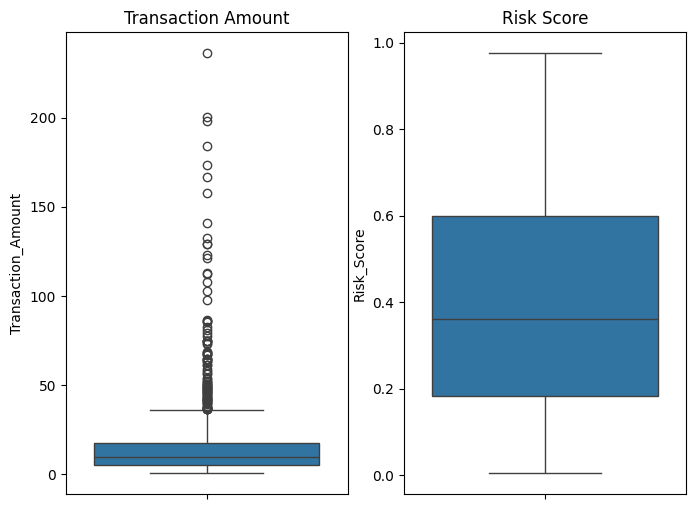

In [213]:
#Check for Outliers
fig, axes = plt.subplots(1, 2,figsize=(8, 6)) 

#Create a box plot for the entire DataFrame
sns.boxplot(fraud_df['Transaction_Amount'],ax=axes[0]).set_title('Transaction Amount')
sns.boxplot(fraud_df['Risk_Score'],ax=axes[1]).set_title('Risk Score')

# Show the plot
plt.show()

**The column 'Transaction_Amount' has outliers which will be removed to improve model performance**

<h3 align="center">Handle Outliers by Winsorization</h3>

In [214]:
# Winsorize the 'Transaction_Amount' column
fraud_df['Transaction_Amount'] =stats.mstats.winsorize(fraud_df['Transaction_Amount'], limits=[0.1, 0.1])



**This technique reduces the effect of outliers by capping extreme values at a threshold and 0.1 was used so that the most extreme outliers are affected (mild form of Winsorization)**

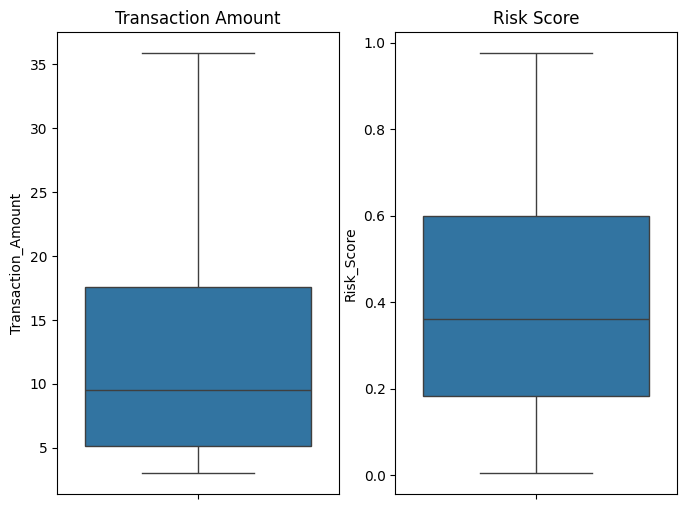

In [215]:
#Check for Outliers after winzorization
fig, axes = plt.subplots(1, 2,figsize=(8, 6)) 

#Create a box plot for the entire DataFrame
sns.boxplot(fraud_df['Transaction_Amount'],ax=axes[0]).set_title('Transaction Amount')
sns.boxplot(fraud_df['Risk_Score'],ax=axes[1]).set_title('Risk Score')

# Show the plot
plt.show()

<h3 align="center">Creating Dummy Variables</h3>

In [216]:
#Label enconding
from sklearn.preprocessing import LabelEncoder
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the data to convert labels into numeric values
fraud_df['Customer_Age_Group']=label_encoder.fit_transform(fraud_df['Customer_Age_Group'])
fraud_df['Transaction_Time']=label_encoder.fit_transform(fraud_df['Transaction_Time'])

#One hot encoding will be used to create dummy variables for each variable to be treated independent of each other
#Identify all non numerical columns
obj_col = [col for col in fraud_df.columns if fraud_df[col].dtype == 'object']

#Onehot encoding
fraud_df = pd.get_dummies(fraud_df, columns=obj_col,drop_first=True)

#Identify dummy columns and convert boolean values to integers
dummy_col = [col for col in fraud_df.columns if fraud_df[col].dtype == 'bool']
fraud_df[dummy_col] = fraud_df[dummy_col].astype(int)

#fraud_df.head(5)

<h3 align="center">Assessing Correlation and Multicollinearity</h3>

In [217]:
correlation_matrix = fraud_df.corr()
plt.figure(figsize=(10, 8))  
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

# Save the heatmap as an image file
output_filename = "correlation_heatmap_output.png"
plt.savefig(output_filename, dpi=300, bbox_inches='tight')
plt.close()


**There are no columns with a correlation greater than 0.8, therefore, multicollinearity is not present**

In [218]:
#Second Check for Multicollinearity
#Identify all independent variables
independent_variables = [col for col in fraud_df.columns if col != 'Fraudulent']
#Independent variables
X = fraud_df[independent_variables]

#Dependent variable
Y = fraud_df['Fraudulent']

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

print(vif_data)

                         Feature       VIF
0             Transaction_Amount  2.946189
1             Customer_Age_Group  2.513404
2               Transaction_Time  2.430643
3                     Risk_Score  3.685001
4       Merchant_Category_Dining  1.330428
5  Merchant_Category_Electronics  2.449975
6    Merchant_Category_Groceries  2.027347
7     Payment_Method_Credit Card  2.723126
8      Payment_Method_Debit Card  1.966557


**There are no columns with high multicollinearity as the VIF values are less than 5 for each column therefore none needs to be dropped**

<h3 align="center">Assessing Linearity Related to the Log Odds</h3>

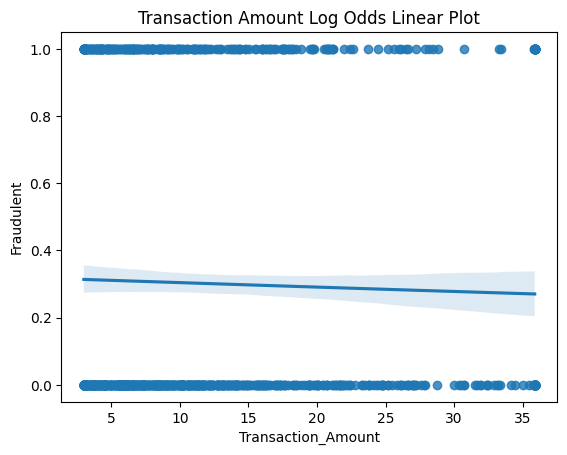

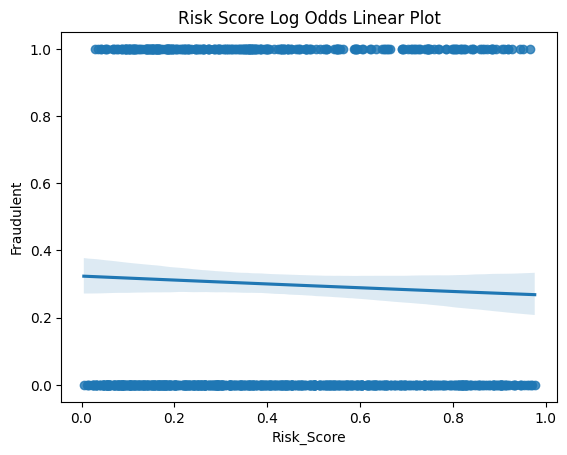

In [219]:
#Create plots to check linearity assumption for numerical variables
trans_amount = sns.regplot(x= 'Transaction_Amount', y= 'Fraudulent', data= fraud_df, logistic= True).set_title("Transaction Amount Log Odds Linear Plot")
plt.show()
                                                                                                         
risk_score = sns.regplot(x= 'Risk_Score', y= 'Fraudulent', data= fraud_df, logistic= True).set_title("Risk Score Log Odds Linear Plot")
plt.show()



**There is a non-linear relationship between independent variables and the logit of the target variable (no presence of a slight curve)-Violates the assumption of the model**

C:\Users\sanes\AppData\Local\Temp\ipykernel_19316\4099436594.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result = fraud_df.groupby('Transaction Amount Bin').agg(


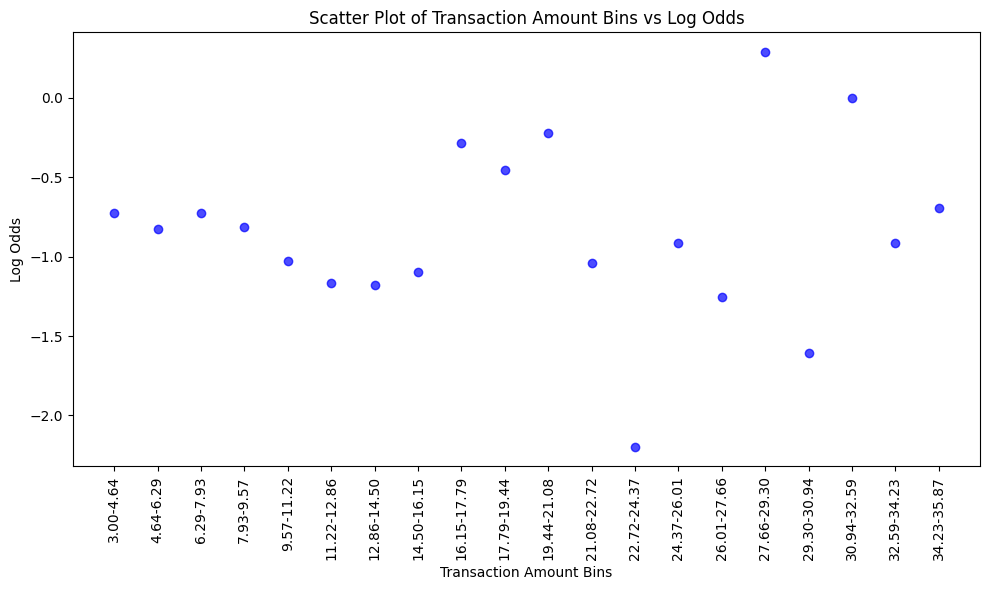

C:\Users\sanes\AppData\Local\Temp\ipykernel_19316\4099436594.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result = fraud_df.groupby('Risk Score Bin').agg(


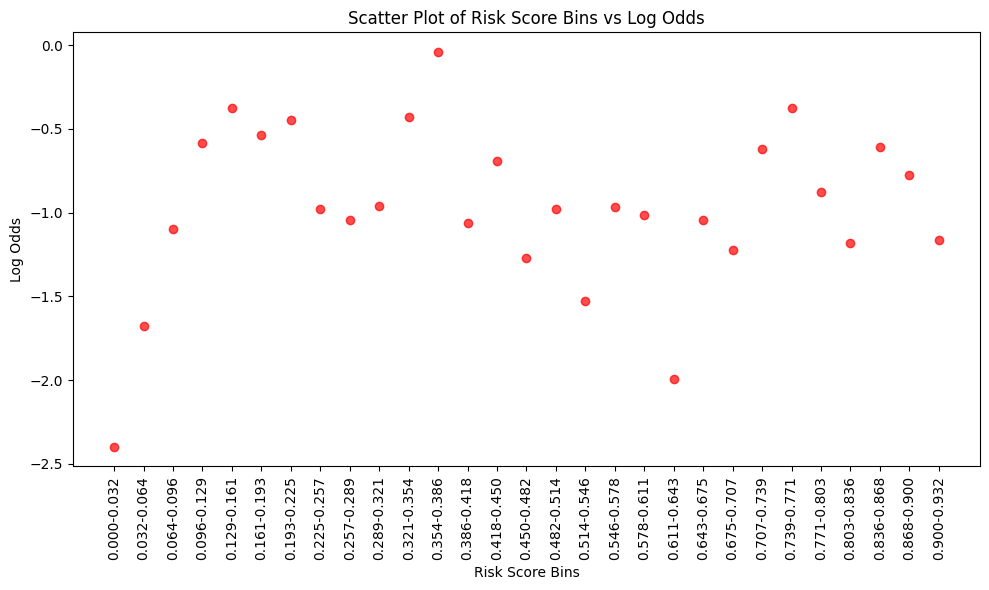

In [220]:
#Transaction Amount Bin
# Create 20 equal-width bins from the minimum to the maximum transaction amount
bins = np.linspace(fraud_df['Transaction_Amount'].min(), fraud_df['Transaction_Amount'].max(), 21)  # 20 bins
labels = [f"{bins[i]:.2f}-{bins[i+1]:.2f}" for i in range(len(bins) - 1)]  # Bin labels

# Add a binned column for transaction amount
fraud_df['Transaction Amount Bin'] = pd.cut(fraud_df['Transaction_Amount'], bins=bins, labels=labels, include_lowest=True, right=False)

# Group by the binned column and calculate required metrics
result = fraud_df.groupby('Transaction Amount Bin').agg(
    Fraud_Transactions=('Fraudulent', 'sum'),  # Number of fraud transactions in each bin
    Non_Fraud_Transactions=('Fraudulent', lambda x: (x == 0).sum()),  # Number of non-fraud transactions
    Total_Transaction_Amount=('Transaction_Amount', 'sum'),  # Total transaction amount in the bin
    Fraud_Transaction_Amount=('Transaction_Amount', lambda x: x[fraud_df.loc[x.index, 'Fraudulent'] == 1].sum())  # Fraud transaction amount
).reset_index()

# Calculate the ratio of fraud to total transactions
result['Fraudulent_Rate'] = result['Fraud_Transactions'] / len(fraud_df)  # Fraud rate by bin (relative to total transactions)

# Calculate cumulative fraud transaction amount percentage by bins
total_fraud_transaction_amount = result['Fraud_Transaction_Amount'].sum()
result['Cumulative_Fraud_Amount_Percentage'] = (result['Fraud_Transaction_Amount'].cumsum() / total_fraud_transaction_amount) * 100

# Calculate odds and log-odds
result['Odds'] = result['Fraud_Transactions'] / result['Non_Fraud_Transactions']
result['Log_Odds'] = np.log(result['Odds'].replace(0, np.nan))  # Avoid log(0) errors by replacing 0 with NaN

# Replace infinite or NaN log-odds with a default value (e.g., 0)
result['Log_Odds'] = result['Log_Odds'].replace([np.inf, -np.inf, np.nan], 0)

# Keep only the requested columns and log-odds
result = result[['Transaction Amount Bin', 'Fraud_Transactions', 'Fraudulent_Rate', 'Non_Fraud_Transactions',
                 'Cumulative_Fraud_Amount_Percentage', 'Log_Odds']]

# Scatter plot of Transaction Amount Bins vs Log Odds
plt.figure(figsize=(10, 6))
plt.scatter(result['Transaction Amount Bin'], result['Log_Odds'], color='blue', alpha=0.7)
plt.xticks(rotation=90)
plt.xlabel('Transaction Amount Bins')
plt.ylabel('Log Odds')
plt.title('Scatter Plot of Transaction Amount Bins vs Log Odds')
plt.tight_layout()
plt.show()

#Risk Score bin
# Assuming `data` is your dataset and using Risk Score bins
bins = np.linspace(0, 0.932, 30)  # Define bins for Risk Score
labels = [f"{bins[i]:.3f}-{bins[i+1]:.3f}" for i in range(len(bins) - 1)]  # Bin labels

# Add a binned column for Risk Score
fraud_df['Risk Score Bin'] = pd.cut(fraud_df['Risk_Score'], bins=bins, labels=labels, right=False)

# Group by Risk Score bins and calculate metrics
result = fraud_df.groupby('Risk Score Bin').agg(
    Fraud_Transactions=('Fraudulent', 'sum'),  # Fraud transactions per bin
    Non_Fraud_Transactions=('Fraudulent', lambda x: (x == 0).sum()),  # Non-fraud transactions per bin
    Total_Transaction_Amount=('Transaction_Amount', 'sum'),  # Total transaction amount per bin
).reset_index()

# Calculate odds and log-odds for Risk Score bins
result['Odds'] = result['Fraud_Transactions'] / result['Non_Fraud_Transactions']
result['Log_Odds'] = np.log(result['Odds'].replace(0, np.nan))  # Avoid log(0) errors by replacing 0 with NaN
result['Log_Odds'] = result['Log_Odds'].replace([np.inf, -np.inf, np.nan], 0)  # Replace invalid log-odds with 0

# Scatter plot of Risk Score bins vs Log Odds
plt.figure(figsize=(10, 6))
plt.scatter(result.index, result['Log_Odds'], color='red', alpha=0.7)
plt.xticks(ticks=result.index, labels=result['Risk Score Bin'], rotation=90)
plt.xlabel('Risk Score Bins')
plt.ylabel('Log Odds')
plt.title('Scatter Plot of Risk Score Bins vs Log Odds')
plt.tight_layout()
plt.show()

**There is no clear correlation between numerical features and the log odds of the target, as the plots scatter randomly.**

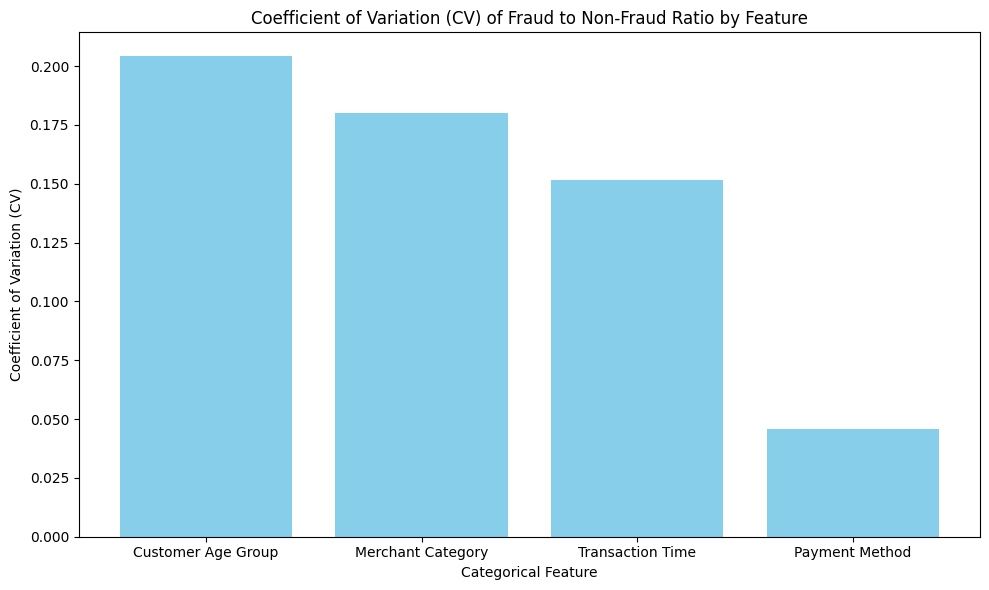

In [221]:
# Group by each categorical variable and calculate Fraud to Non-Fraud Ratio
categorical_columns = ['Customer_Age_Group', 'Merchant_Category', 'Transaction_Time', 'Payment_Method']

cv_results = {}

for col in categorical_columns:
    grouped = fraud_df_copy.groupby(col).agg(
        Fraud_Transactions=('Fraudulent', 'sum'),
        Non_Fraud_Transactions=('Fraudulent', lambda x: (x == 0).sum())
    ).reset_index()
    
    # Calculate Fraud to Non-Fraud Ratio
    grouped['Fraud_to_NonFraud_Ratio'] = grouped['Fraud_Transactions'] / grouped['Non_Fraud_Transactions']
    
    # Calculate the mean and standard deviation of the ratio
    mean_ratio = grouped['Fraud_to_NonFraud_Ratio'].mean()
    std_ratio = grouped['Fraud_to_NonFraud_Ratio'].std()
    
    # Calculate Coefficient of Variation (CV)
    cv = std_ratio / mean_ratio if mean_ratio != 0 else 0
    
    # Store the CV result
    cv_results[col] = cv

# Assume cv_results is populated with the CV values for categorical features
cv_results = {
    'Customer Age Group': 0.2041,  
    'Merchant Category': 0.1800,
    'Transaction Time': 0.1514,
    'Payment Method': 0.0459
}

# Convert the CV results into a DataFrame for easier plotting
cv_df = pd.DataFrame(list(cv_results.items()), columns=['Feature', 'CV'])

# Plot the CV values as a bar chart
plt.figure(figsize=(10, 6))
plt.bar(cv_df['Feature'], cv_df['CV'], color='skyblue')
plt.xlabel('Categorical Feature')
plt.ylabel('Coefficient of Variation (CV)')
plt.title('Coefficient of Variation (CV) of Fraud to Non-Fraud Ratio by Feature')
plt.tight_layout()
plt.show()


**Categorical features with high variability, like Customer Age Group (CV = 0.2041) and Merchant Category (CV = 0.1800), are key for fraud prediction due to their strong differentiation. While low-variability features like Payment Method (CV = 0.0459) may complement other predictors**

## *FEATURE ENGINEERING*

In [222]:
#Scale Data for columns Transaction_Amount and Risk Score
#Initialising the StandardScaler to enable values between 0 and 1
scaler = StandardScaler()

# learning the statistical parameters for each of the data and transforming
fraud_df[['Transaction_Amount','Risk_Score']] = scaler.fit_transform(fraud_df[['Transaction_Amount','Risk_Score']])





## *LOGISTIC REGRESSION MODEL*

In [223]:

#Independent variables
x = fraud_df[independent_variables]

#Dependent variable
y = fraud_df['Fraudulent']




In [224]:
# The below step is too important for the training and building the model
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=5)

#Implement SMOTE
smote = SMOTE(random_state=542)

#Ensure that SMOTE is only used on the training set and not the test set
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

# Count the number of fraudulent cases vs the number of non-fraudulent cases
print(pd.value_counts(y_train_resampled))

# The below two steps are to initiate and build the model
model = LogisticRegression(penalty='l2', C=1e42, solver='liblinear')
result= model.fit(x_train_resampled, y_train_resampled)


# Here we will predict the y value
y_pred_test = result.predict(x_test)



Fraudulent
0    566
1    566
Name: count, dtype: int64


C:\Users\sanes\AppData\Local\Temp\ipykernel_19316\3618326176.py:11: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  print(pd.value_counts(y_train_resampled))


**After using the SMOTE technique the number of non fradulent cases were equal to the number of fradulent ones, dataset is now balanced**

**A test size of 20% of the original dataset was selected because the dataset only has 1000 records and hence needs sufficient data to train the model**

<h3 align="center">AIC Score</h3>

In [225]:

print('intercept ', result.intercept_[0])
print(pd.DataFrame({'coeff': result.coef_[0]}, index=x.columns).transpose())
print()
print('AIC', AIC_score(y_test, result.predict(x_test), df = len(x_train.columns) + 1))


intercept  0.8510339879933402
       Transaction_Amount  Customer_Age_Group  Transaction_Time  Risk_Score  \
coeff           -0.042034           -0.002625         -0.128555    -0.05726   

       Merchant_Category_Dining  Merchant_Category_Electronics  \
coeff                 -0.847646                      -0.175826   

       Merchant_Category_Groceries  Payment_Method_Credit Card  \
coeff                    -0.534176                   -0.493774   

       Payment_Method_Debit Card  
coeff                  -0.599094  

AIC 411.2557894251123


**The model based on all 9 predictors has has the estimated logistic regression equation**

<h3 align="center">Evaluating Classification Performance</h3>

In [226]:
logit_reg_pred = result.predict(x_test)
logit_reg_proba = result.predict_proba(x_test)
logit_result = pd.DataFrame({'actual': y_test,
'p(0)': [p[0] for p in logit_reg_proba],
'p(1)': [p[1] for p in logit_reg_proba],
'predicted': logit_reg_pred })


# display four different cases
interestingCases = [500, 3, 756, 929]
print(logit_result.loc[interestingCases])



     actual      p(0)      p(1)  predicted
500       0  0.467547  0.532453          1
3         0  0.399265  0.600735          1
756       1  0.439721  0.560279          1
929       0  0.313071  0.686929          1


**Using sample cases from the test set the model's performance was poor**

In [227]:
#Prediction on the Test Set
accuracy = accuracy_score(y_test,y_pred_test)
print("The accuracy value is ", accuracy)

precision =precision_score(y_test, y_pred_test,zero_division=0)
print("The precision is", precision)


The accuracy value is  0.59
The precision is 0.4111111111111111


**The precision metric was used to assess the true positive transactions out of all transactions predicted as fraud** 

**The accuracy metric was used to evaluate the proportion of correct predictions out of all predictions**

<h3 align="center">Confusion Matrix</h3>

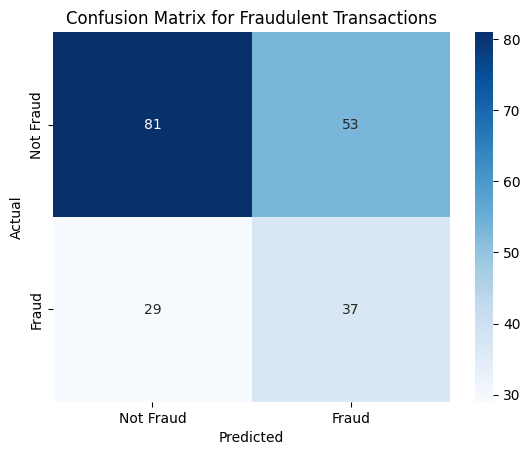

In [228]:
# Compute the confusion matrix for test set
conf_matrix = confusion_matrix(y_test,y_pred_test)

# Visualize the confusion matrix using heatmap
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Fraudulent Transactions')
plt.show()


<h3 align="center">Gains and Decile Lift Chart</h3>

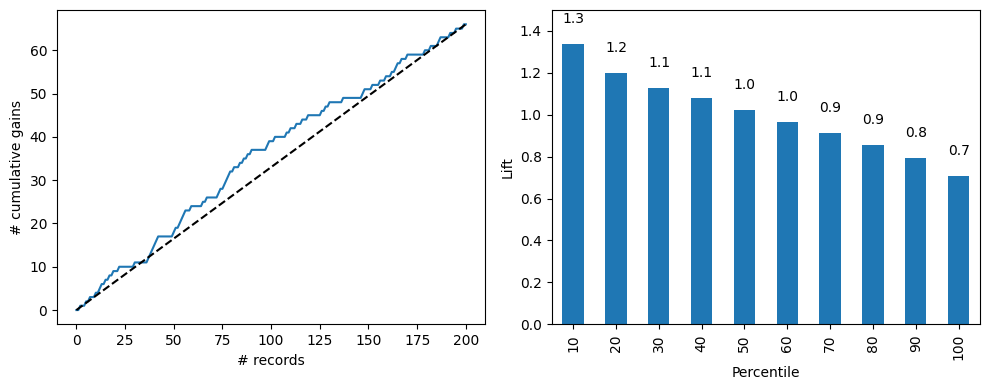

In [229]:
df = logit_result.sort_values(by=['p(1)'], ascending=False)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
gainsChart(df.actual, ax=axes[0])
liftChart(df['p(1)'], title=False, ax=axes[1])
plt.tight_layout()
plt.show()


**The model is not effective in predicting fraudulent transactions as the curve is close to the baseline on the gains chart**

**Also using the decile lift chart there is no steep drop present as we move down the deciles which is another indicator of an ineffective model**